In [2]:
import pennylane as qml
from pennylane import qchem
from pennylane import numpy as np
import time
import matplotlib.pyplot as plt

In [3]:
help(qml.qchem.molecular_hamiltonian)

Help on function molecular_hamiltonian in module pennylane.qchem.openfermion_obs:

molecular_hamiltonian(symbols, coordinates, name='molecule', charge=0, mult=1, basis='sto-3g', method='dhf', active_electrons=None, active_orbitals=None, mapping='jordan_wigner', outpath='.', wires=None, alpha=None, coeff=None, args=None, grouping_type=None, grouping_method='rlf')
    Generate the qubit Hamiltonian of a molecule.
    
    This function drives the construction of the second-quantized electronic Hamiltonian
    of a molecule and its transformation to the basis of Pauli matrices.
    
    The net charge of the molecule can be given to simulate cationic/anionic systems. Also, the
    spin multiplicity can be input to determine the number of unpaired electrons occupying the HF
    orbitals as illustrated in the left panel of the figure below.
    
    The basis of Gaussian-type *atomic* orbitals used to represent the *molecular* orbitals can be
    specified to go beyond the minimum basis app

In [4]:
symbols = ["H","H"]
geometry = np.array([[0.0,0.0,-0.70],[0.0, 0.0, 0.70]])

H, qubits = qml.qchem.molecular_hamiltonian(symbols,geometry,charge=0)

In [5]:
print(H)

  (-0.22304019968520916) [Z2]
+ (-0.22304019968520916) [Z3]
+ (-0.09815626345048423) [I0]
+ (0.171282493274637) [Z0]
+ (0.171282493274637) [Z1]
+ (0.1205765190279041) [Z0 Z2]
+ (0.1205765190279041) [Z1 Z3]
+ (0.16589099757500472) [Z0 Z3]
+ (0.16589099757500472) [Z1 Z2]
+ (0.16864852145292916) [Z0 Z1]
+ (0.17437383589859615) [Z2 Z3]
+ (-0.04531447854710061) [Y0 Y1 X2 X3]
+ (-0.04531447854710061) [X0 X1 Y2 Y3]
+ (0.04531447854710061) [Y0 X1 X2 Y3]
+ (0.04531447854710061) [X0 Y1 Y2 X3]


In [4]:
print(qubits)

8


In [6]:
generators = qml.symmetry_generators(H)
paulixops = qml.paulix_ops(generators,qubits)

In [7]:
for idx, generator in enumerate(generators):
    print(f"generator {idx+1}: {generator}, paulix_op: {paulixops[idx]}")

generator 1:   (1.0) [Z0 Z1], paulix_op: PauliX(wires=[1])
generator 2:   (1.0) [Z0 Z2], paulix_op: PauliX(wires=[2])
generator 3:   (1.0) [Z0 Z3], paulix_op: PauliX(wires=[3])


In [8]:
n_electrons = 2
paulix_sector = qml.qchem.optimal_sector(H,generators,n_electrons)
print(paulix_sector)

[1, -1, -1]


In [9]:
H_tapered = qml.taper(H, generators, paulixops, paulix_sector)
print(H_tapered)

  ((-0.32806893930477643+0j)) [I0]
+ ((0.18125791418840234+0j)) [X0]
+ ((0.7886453859196918+0j)) [Z0]


In [9]:
H_sparse = qml.SparseHamiltonian(qml.utils.sparse_hamiltonian(H), wires=H.wires)
H_tapered_sparse = qml.SparseHamiltonian(qml.utils.sparse_hamiltonian(H_tapered), wires=H_tapered.wires)

print("Eigenvalues of H:\n", qml.eigvals(H_sparse, k=16))
print("\nEigenvalues of H_tapered:\n", qml.eigvals(H_tapered_sparse, k=4))

Eigenvalues of H:
 [-1.47924833 -0.90625234 -0.90625234 -0.15277341 -0.50270799 -0.50270799
 -0.36077427 -0.36077427  0.2082724   0.2396423  -0.39067699 -0.39067699
 -0.39067699  0.01044941  0.01044941  0.01044941]

Eigenvalues of H_tapered:
 [-1.47924833  0.01044941  0.2082724   0.92486939]


In [10]:
state_tapered = qml.qchem.taper_hf(generators, paulixops, paulix_sector,
                                   num_electrons=n_electrons, num_wires=len(H.wires))
print(state_tapered)

[1 1 1 1 0]


In [11]:
singles, doubles = qml.qchem.excitations(n_electrons, len(H.wires))
tapered_doubles = [ qchem.taper_operation(qml.DoubleExcitation, generators, paulixops, paulix_sector,
                        wire_order=H.wires, op_wires=double) for double in doubles]
tapered_singles = [
    qchem.taper_operation(qml.SingleExcitation, generators, paulixops, paulix_sector,
                        wire_order=H.wires, op_wires=single) for single in singles]

dev = qml.device("default.qubit", wires=H_tapered.wires)
@qml.qnode(dev)
def tapered_circuit(params):
    qml.BasisState(state_tapered, wires=H_tapered.wires)
    for idx, tapered_op in enumerate(tapered_doubles + tapered_singles):
        tapered_op(params[idx])
    return qml.expval(H_tapered)


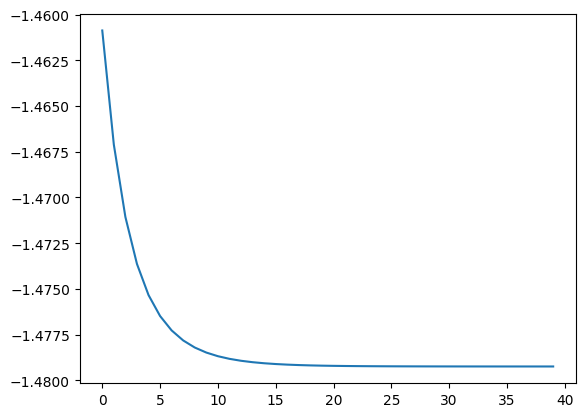

In [14]:
optimizer = qml.GradientDescentOptimizer(stepsize=0.1)
params = np.zeros(len(doubles) + len(singles), requires_grad=True)
energy_list = []
for n in range(1, 41):
    params, energy = optimizer.step_and_cost(tapered_circuit, params)
    energy_list.append(energy)
        
plt.plot(energy_list) 

In [15]:
print(qml.draw(tapered_circuit)(params))

0: ─╭BasisState(M0)─╭Exp(-0.00-0.01j Y@Y@Y)─╭Exp(0.00+0.01j X@X@Y)─╭Exp(-0.00-0.01j X@Y@X)
1: ─├BasisState(M0)─├Exp(-0.00-0.01j Y@Y@Y)─├Exp(0.00+0.01j X@X@Y)─├Exp(-0.00-0.01j X@Y@X)
2: ─├BasisState(M0)─│───────────────────────│──────────────────────│──────────────────────
3: ─├BasisState(M0)─│───────────────────────│──────────────────────│──────────────────────
4: ─╰BasisState(M0)─╰Exp(-0.00-0.01j Y@Y@Y)─╰Exp(0.00+0.01j X@X@Y)─╰Exp(-0.00-0.01j X@Y@X)

──╭Exp(-0.00-0.01j Y@X@X)─╭Exp(0.00+0.00j Y@X@Z@Z)─╭Exp(0.00+0.00j Y@X@Z@Z)─╭Exp(-0.00-0.00j X@Y)
──├Exp(-0.00-0.01j Y@X@X)─├Exp(0.00+0.00j Y@X@Z@Z)─├Exp(0.00+0.00j Y@X@Z@Z)─╰Exp(-0.00-0.00j X@Y)
──│───────────────────────│────────────────────────├Exp(0.00+0.00j Y@X@Z@Z)──────────────────────
──│───────────────────────├Exp(0.00+0.00j Y@X@Z@Z)─│─────────────────────────────────────────────
──╰Exp(-0.00-0.01j Y@X@X)─╰Exp(0.00+0.00j Y@X@Z@Z)─╰Exp(0.00+0.00j Y@X@Z@Z)──────────────────────

──╭Exp(-0.00-0.00j X@Y@Z@Z)─╭Exp(-0.00-0.00j Y@X)─╭Ex